In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import model_selection, preprocessing
from sklearn.metrics import mean_squared_error
import math

%matplotlib inline

In [3]:
hourly = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\daily_station35.csv")
hourly.head()

,startday,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude
0,2013-08-05,35,64,Streeter Dr & Grand Ave,41.892278,-87.612043
1,2013-08-06,35,169,Streeter Dr & Grand Ave,41.892278,-87.612043
2,2013-08-07,35,117,Streeter Dr & Grand Ave,41.892278,-87.612043
3,2013-08-08,35,193,Streeter Dr & Grand Ave,41.892278,-87.612043
4,2013-08-09,35,238,Streeter Dr & Grand Ave,41.892278,-87.612043


In [4]:
#any null value?
hourly.isnull().sum()
hourly.startday =  pd.to_datetime(hourly.startday, errors="coerce")
hourly.dtypes

startday                  datetime64[ns]
from_station_id                    int64
num_trips                          int64
from_station_name                 object
from_station_latitude            float64
from_station_longitude           float64
dtype: object

In [5]:
#feature engineering
#Dervice weekday and weekend
#convert column data into appropriate
dateTimeIndex = pd.DatetimeIndex(hourly['startday'])
hourly["day"] = dateTimeIndex.dayofweek
hourly["month"] = dateTimeIndex.month
hourly['year']= dateTimeIndex.year
hourly["day_name"] = dateTimeIndex.dayofweek
hourly["tripdate"] = dateTimeIndex.day

hourly.head()

,startday,from_station_id,num_trips,from_station_name,from_station_latitude,from_station_longitude,day,month,year,day_name,tripdate
0,2013-08-05,35,64,Streeter Dr & Grand Ave,41.892278,-87.612043,0,8,2013,0,5
1,2013-08-06,35,169,Streeter Dr & Grand Ave,41.892278,-87.612043,1,8,2013,1,6
2,2013-08-07,35,117,Streeter Dr & Grand Ave,41.892278,-87.612043,2,8,2013,2,7
3,2013-08-08,35,193,Streeter Dr & Grand Ave,41.892278,-87.612043,3,8,2013,3,8
4,2013-08-09,35,238,Streeter Dr & Grand Ave,41.892278,-87.612043,4,8,2013,4,9


In [6]:
#define weekday
weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_dict = {key: weekday_name[key] for key in range(7)}

def day_of_week(idx):
    return weekday_dict[idx]
hourly.day_name = hourly.day_name.apply(day_of_week)


In [7]:
#function to define seasons
def date2season(df):
    #dateTimeIndex = pd.DatetimeIndex(df)
  
    md = df.month * 100 + df.day

    if (md > 320 and md < 621):
        s = 0    #Spring
    elif (md > 620 and md < 923):
        s = 1   #Summer
    elif (md > 922 and md < 1223):
        s = 2   #Fall
    else:
        s = 3   #Winter

        '''
    if hemisphere != 'north':
        if s < 2:
            s += 2 
        else:
            s -= 2
        '''
    return s

d1 = hourly.startday.apply(date2season)
hourly["season"] = d1


In [8]:
#define weekday
seasons = ["Spring", "Summer", "Fall", "Winter"]
season_dict = {key: seasons[key] for key in range(4)}

def season_name(idx):
    return season_dict[idx]

hourly["seasons_name"] = hourly.season.apply(season_name)


In [9]:
#Finding hoildays
#pip install holidays
#package holidays 0.8.1

import holidays as hh
holidaysArr = []

for x in (2013, 2014, 2015, 2016, 2017):
    for date, name in sorted(hh.US(state='IL', years=x).items()):
        holidaysArr.append(date)

holidays_US = pd.DatetimeIndex(holidaysArr)

def USHolidays(startday):
    dt = pd.to_datetime(startday)
    i = 0
    if dt in holidays_US :
        i = 1    #holiday
    
    return i

hourly["IsHoliday"] = hourly.startday.apply(USHolidays)

In [10]:
#Weather data
wt = pd.read_csv("C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\weatherDataDaily.csv")
wt.startday =  pd.to_datetime(wt.startday, errors="coerce")

resultData = pd.merge(hourly, wt, on=['startday'])
#resultData.head()

In [11]:
# Create a set of dummy variables from the weather feature
df_weather = pd.get_dummies(resultData['weather'])
df_weather.head()

,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [12]:
#join dummy dataframe in original
resultData_new = pd.concat([resultData, df_weather], axis=1)
#resultData.drop('weatherCode', axis=1)
resultData_new.dtypes

startday                  datetime64[ns]
from_station_id                    int64
num_trips                          int64
from_station_name                 object
from_station_latitude            float64
from_station_longitude           float64
day                                int32
month                              int32
year                               int32
day_name                          object
tripdate                           int32
season                             int64
seasons_name                      object
IsHoliday                          int64
weather                           object
humidity                         float64
temperatureMax                   float64
temperatureMin                   float64
windspeed                        float64
CLEAR_DAY                          uint8
FOG                                uint8
PARTLY_CLOUDY_DAY                  uint8
PARTLY_CLOUDY_NIGHT                uint8
RAIN                               uint8
SNOW            

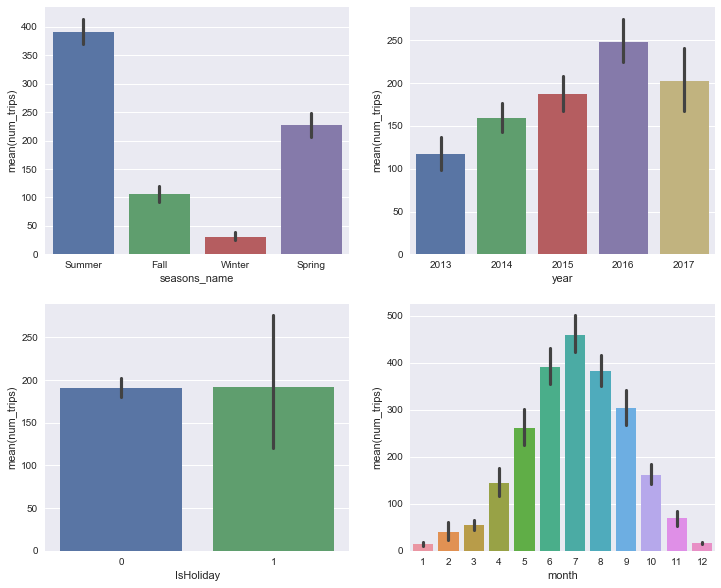

In [13]:
#at from_station_id=35
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sns.barplot(data=resultData_new, y="num_trips", x="seasons_name",orient="v",ax=axes[0][0])
sns.barplot(data=resultData_new, y="num_trips", x="year",orient="v",ax=axes[0][1])
sns.barplot(data=resultData_new, y="num_trips", x="IsHoliday", orient="v",ax=axes[1][0])
sns.barplot(data=resultData_new, y="num_trips", x="month",orient="v",ax=axes[1][1])

               weather  num_trips
0            CLEAR_DAY      87119
2    PARTLY_CLOUDY_DAY      78003
6                 WIND      39979
4                 RAIN      38077
3  PARTLY_CLOUDY_NIGHT      17908
1                  FOG       3459
5                 SNOW        138


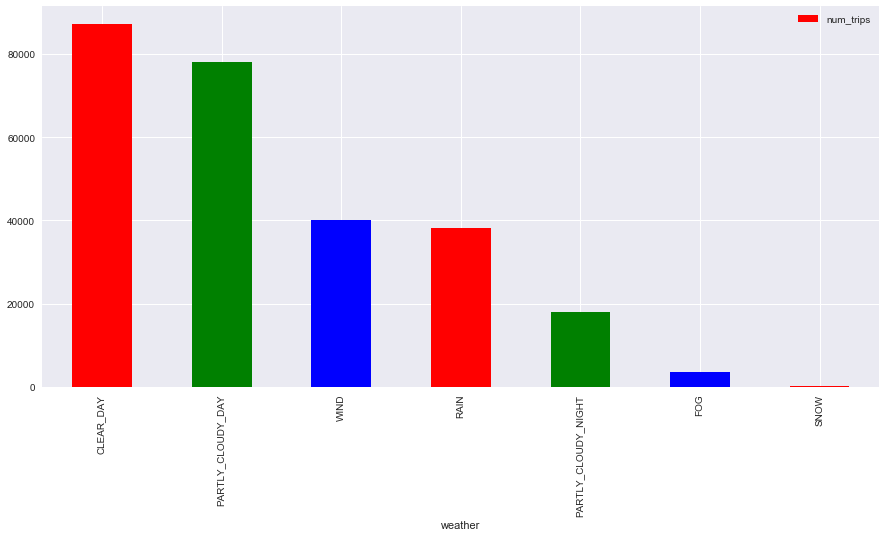

In [14]:
df_weathergrouped = resultData_new.groupby('weather').num_trips.sum().to_frame()
df_weathergrouped.sort_values

weather_df_sorted = df_weathergrouped.reset_index('weather').sort_values(['num_trips'], 
                                                                         ascending = [False])
print(weather_df_sorted)
#fig1, axes = plt.subplots(nrows=1, ncols=1)
#fig1.set_size_inches(15, 10)

weather_df_sorted.plot.bar(x='weather', y='num_trips', figsize=(15, 7), color='rgb')
#sns.barplot(data=df_top5, y="num_trips", x="weather",orient="v")
#plt.show()

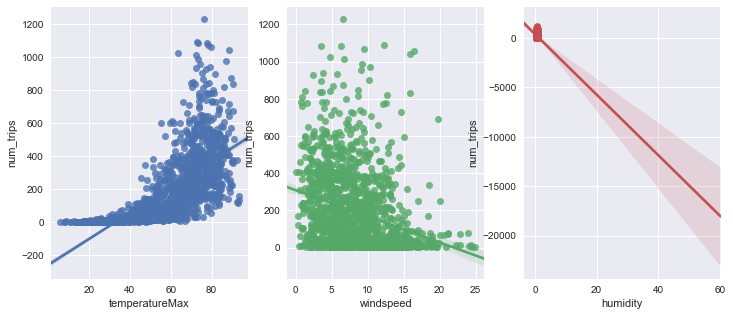

In [15]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temperatureMax", y="num_trips", data=resultData,ax=ax1)
sns.regplot(x="windspeed", y="num_trips", data=resultData,ax=ax2)
sns.regplot(x="humidity", y="num_trips", data=resultData,ax=ax3)

In [16]:
#Categorize variables
categoricalVariables = ["from_station_id","from_station_name","month", "year", "season", "seasons_name", "IsHoliday",
                       "weather", "day_name", "day", "tripdate", 'CLEAR_DAY', 'FOG',
       'PARTLY_CLOUDY_DAY', 'PARTLY_CLOUDY_NIGHT', 'RAIN', 'SNOW', 'WIND']
for var in categoricalVariables:
    resultData_new[var] = resultData_new[var].astype("category")

resultData_new.dtypes


startday                  datetime64[ns]
from_station_id                 category
num_trips                          int64
from_station_name               category
from_station_latitude            float64
from_station_longitude           float64
day                             category
month                           category
year                            category
day_name                        category
tripdate                        category
season                          category
seasons_name                    category
IsHoliday                       category
weather                         category
humidity                         float64
temperatureMax                   float64
temperatureMin                   float64
windspeed                        float64
CLEAR_DAY                       category
FOG                             category
PARTLY_CLOUDY_DAY               category
PARTLY_CLOUDY_NIGHT             category
RAIN                            category
SNOW            

In [17]:
#Outlier are present, will check with model, how model is better without outliers
resultDataWithoutOutliers = resultData_new[np.abs(resultData_new["num_trips"]-resultData_new["num_trips"].mean())
                                           <=(3*resultData_new["num_trips"].std())]

print("Before Ouliers removal: ",resultData.shape)
print("After Ouliers removal: ",resultDataWithoutOutliers.shape)


Before Ouliers removal:  (1384, 19)
After Ouliers removal:  (1361, 26)


In [18]:
#Correlation Analysis

df_numerical = resultData_new.drop(['from_station_longitude', 'from_station_name', 'from_station_id', 'year', 'day', 'day_name', 'seasons_name', 
                     'from_station_latitude', 'weather'], axis=1)

df_numerical.head()
df_numerical.corr()

,num_trips,humidity,temperatureMax,temperatureMin,windspeed
num_trips,1.000000,-0.165255,0.700211,0.683838,-0.282625
humidity,-0.165255,1.000000,-0.011761,0.093552,-0.080563
temperatureMax,0.700211,-0.011761,1.000000,0.954309,-0.238417
temperatureMin,0.683838,0.093552,0.954309,1.000000,-0.266157
windspeed,-0.282625,-0.080563,-0.238417,-0.266157,1.000000


In [19]:
df_numerical.set_index(['startday'])
df_sorted = df_numerical.sort_index(level='startday')

df_sorted.head()

,startday,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND
0,2013-08-05,64,8,5,1,0,0.71,73.41,62.73,7.32,1,0,0,0,0,0,0
1,2013-08-06,169,8,6,1,0,0.78,81.36,67.74,7.29,1,0,0,0,0,0,0
2,2013-08-07,117,8,7,1,0,0.77,83.63,69.75,2.13,1,0,0,0,0,0,0
3,2013-08-08,193,8,8,1,0,0.64,73.02,67.75,10.33,1,0,0,0,0,0,0
4,2013-08-09,238,8,9,1,0,0.63,78.74,64.03,1.06,1,0,0,0,0,0,0


In [20]:
#defining method to Test for stationary with ADF test
from statsmodels.tsa.stattools import adfuller
def isStationary(tsData):

    rollingmean = pd.rolling_mean(tsData, window=7, min_periods=1)
    fig = plt.figure(figsize=(15, 8))
    orig = plt.plot(tsData, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Timeseries data')
    plt.show()
    
    print('ADF Test result:')
    
    result = adfuller(tsData, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
        
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    

C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


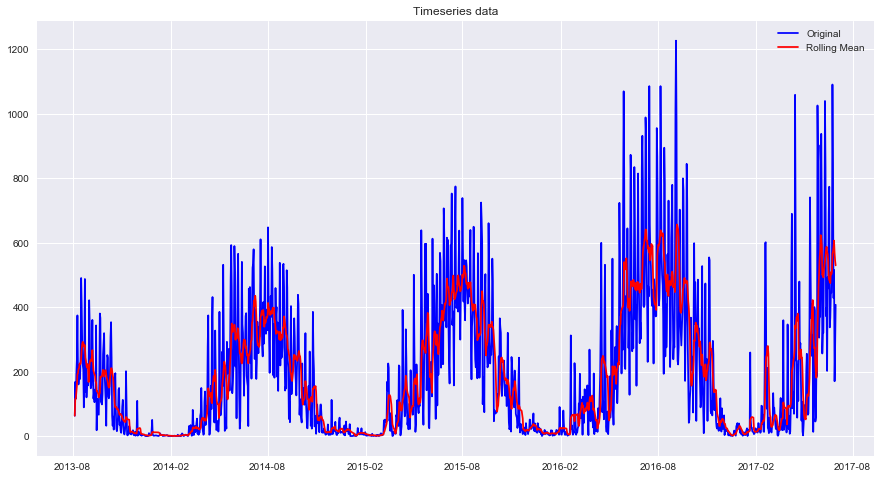

ADF Test result:
ADF Statistic: -1.779845
p-value: 0.390513
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [21]:
#Test for stationary with ADF test
#H0: timeseries data is non-stationary
#H1 timeserise data is stationary

#as p-value is > 0.05
#fail to reject null-hypothesis
#i.e. Data is non-stationary

#Perform Dickey-Fuller test on original data

t4 = df_sorted.groupby(['startday']).num_trips.sum().to_frame()
index_df = df_sorted.set_index('startday')
isStationary(index_df.num_trips)

In [22]:
#timeseries data is not stationary. first make it stationary. and then split

index_df['diff_num_trips_1'] = index_df.num_trips.diff(periods=1)
index_df['diff_num_trips_2'] = index_df.num_trips.diff(periods=2)
index_df['diff_num_trips_3'] = index_df.num_trips.diff(periods=3)
index_df['diff_num_trips_4'] = index_df.num_trips.diff(periods=4)

index_df['diff_num_trips_1'] = index_df.diff_num_trips_1.fillna(0)
index_df['diff_num_trips_2'] = index_df.diff_num_trips_2.fillna(0)
index_df['diff_num_trips_3'] = index_df.diff_num_trips_3.fillna(0)
index_df['diff_num_trips_4'] = index_df.diff_num_trips_4.fillna(0)
index_df.head()

,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,diff_num_trips_1,diff_num_trips_2,diff_num_trips_3,diff_num_trips_4
startday,,,,,,,,,,,,,,,,,,,,
2013-08-05,64,8,5,1,0,0.71,73.41,62.73,7.32,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2013-08-06,169,8,6,1,0,0.78,81.36,67.74,7.29,1,0,0,0,0,0,0,105.0,0.0,0.0,0.0
2013-08-07,117,8,7,1,0,0.77,83.63,69.75,2.13,1,0,0,0,0,0,0,-52.0,53.0,0.0,0.0
2013-08-08,193,8,8,1,0,0.64,73.02,67.75,10.33,1,0,0,0,0,0,0,76.0,24.0,129.0,0.0
2013-08-09,238,8,9,1,0,0.63,78.74,64.03,1.06,1,0,0,0,0,0,0,45.0,121.0,69.0,174.0


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


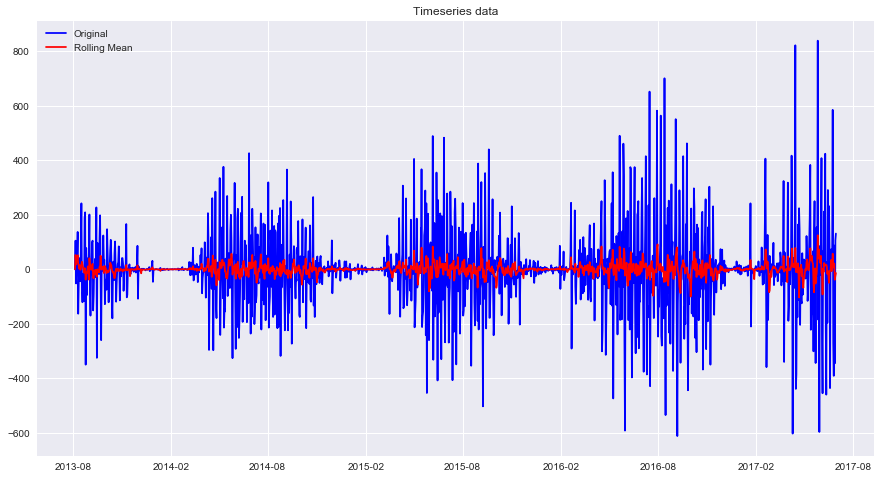

ADF Test result:
ADF Statistic: -10.755449
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [23]:
index_df.dropna(inplace=True)
isStationary(index_df.diff_num_trips_1)

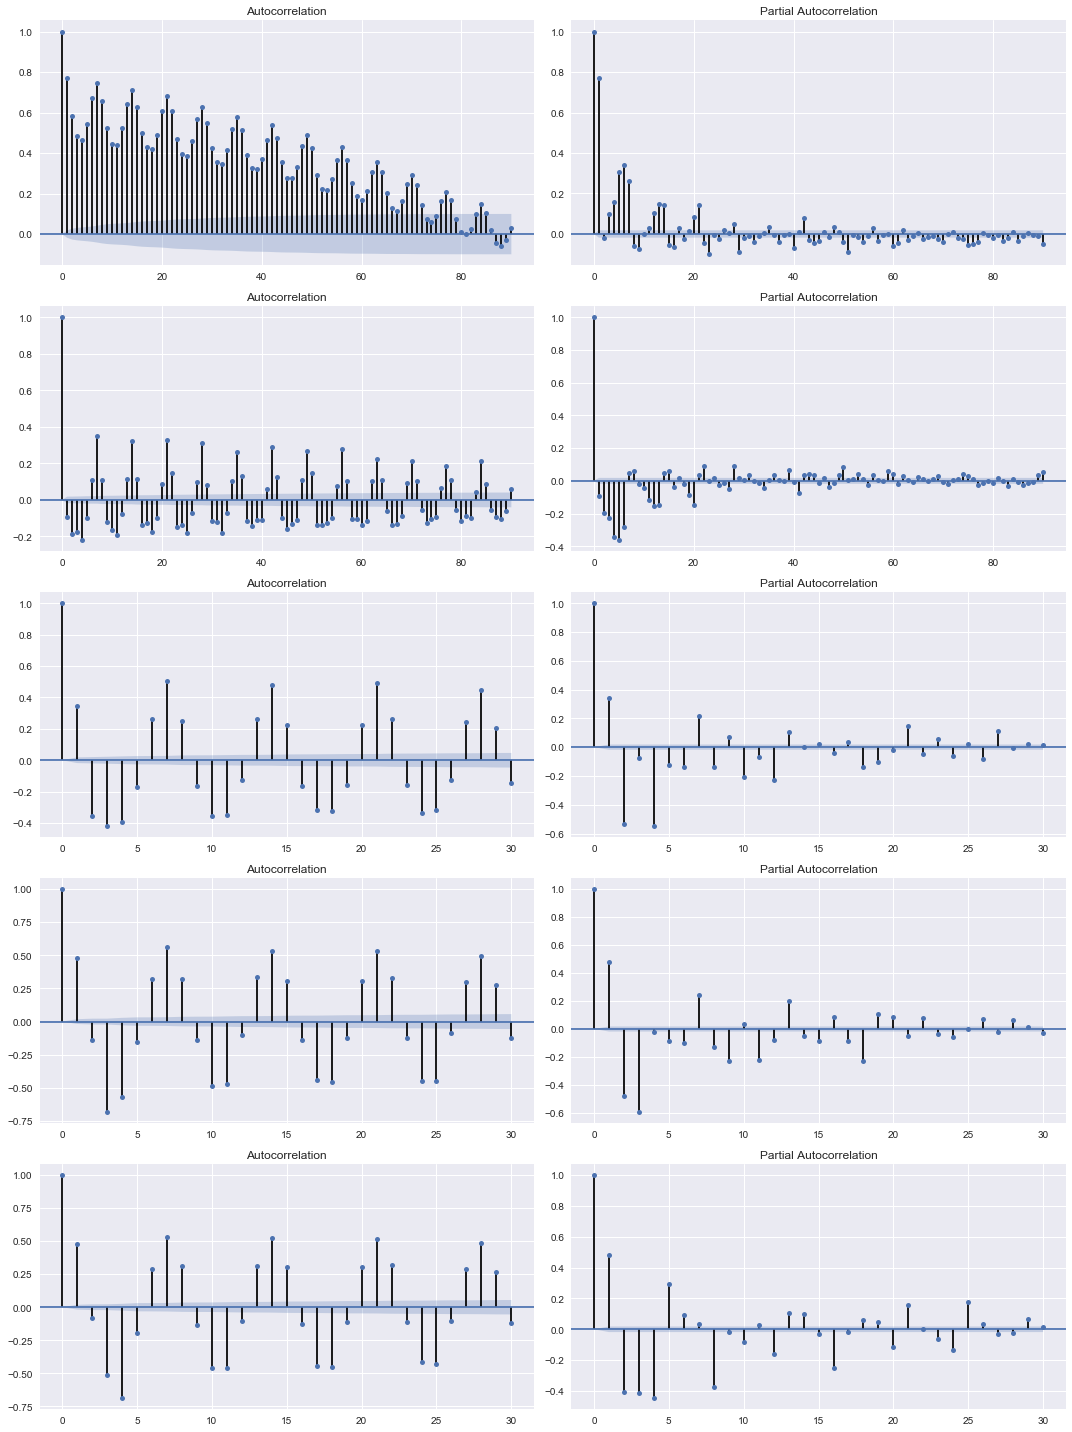

In [165]:
#ACF test
'''
ACF: A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function (ACF).
'''
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot ACF and PCF on stationary data
#fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig, axes = plt.subplots(nrows=5, ncols=2)
fig.set_size_inches(15, 20)

plot_acf(index_df.num_trips, lags=90, ax=axes[0][0], alpha=0.5)
plot_pacf(index_df.num_trips, lags=90, ax=axes[0][1], alpha=0.5)

plot_acf(index_df.diff_num_trips_1, lags=90, ax=axes[1][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_1, lags=90, ax=axes[1][1], alpha=0.5)


plot_acf(index_df.diff_num_trips_2, lags=30, ax=axes[2][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_2, lags=30, ax=axes[2][1], alpha=0.5)

plot_acf(index_df.diff_num_trips_3, lags=30, ax=axes[3][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_3, lags=30, ax=axes[3][1], alpha=0.5)

plot_acf(index_df.diff_num_trips_4, lags=30, ax=axes[4][0], alpha=0.5)
plot_pacf(index_df.diff_num_trips_4, lags=30, ax=axes[4][1], alpha=0.5)


plt.tight_layout()



In [169]:
#timeseries data is not stationary. first make it stationary. and then split

df_monthly = index_df
df_monthly['num_trips_30mean'] = df_monthly.num_trips.resample('MS').mean()

#df_monthly['t_1'] = df_monthly.num_trips_30mean.diff(periods=1)
#df_monthly['t_2'] = df_monthly.num_trips_30mean.diff(periods=2)

df_monthly.head()

,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,...,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,diff_num_trips_1,diff_num_trips_2,diff_num_trips_3,diff_num_trips_4,humidity_scaled,num_trips_30mean
startday,,,,,,,,,,,,,,,,,,,,,
2013-08-05,64,8,5,1,0,0.71,73.41,62.73,7.32,1,...,0,0,0,0,0.0,0.0,0.0,0.0,0.073612,NaN
2013-08-06,169,8,6,1,0,0.78,81.36,67.74,7.29,1,...,0,0,0,0,105.0,0.0,0.0,0.0,0.679516,NaN
2013-08-07,117,8,7,1,0,0.77,83.63,69.75,2.13,1,...,0,0,0,0,-52.0,53.0,0.0,0.0,0.592959,NaN
2013-08-08,193,8,8,1,0,0.64,73.02,67.75,10.33,1,...,0,0,0,0,76.0,24.0,129.0,0.0,-0.532293,NaN
2013-08-09,238,8,9,1,0,0.63,78.74,64.03,1.06,1,...,0,0,0,0,45.0,121.0,69.0,174.0,-0.618851,NaN


In [25]:
#splitting data into 60%, 20% 20% ration
def train_validate_test_split(df):
    train = pd.DataFrame(df.loc['20130805':'20160131'])
    validate = pd.DataFrame(df.loc['20160201':'20160930'])
    test = pd.DataFrame(df.loc['20161001':'20170630'])
    return train, validate, test

train, validate, test = train_validate_test_split(index_df)

In [26]:
print(train.shape)
print(validate.shape)
print(test.shape)

(868, 20)
(243, 20)
(273, 20)


In [28]:
#Creating baseline on validation dataset
#mean squared error on validation data

train, validate, test = train_validate_test_split(t4)

v1 = validate
y = v1.num_trips
y_pred = rollingmean = pd.rolling_mean(v1.num_trips, window=7, min_periods=1) # v1.rollingmean

mse = mean_squared_error(y, y_pred)

print("mean squared error: %f" % mse)
print("root mean squared error: %f" % math.sqrt(mse))


mean squared error: 34406.367341
root mean squared error: 185.489534


C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


In [123]:
#plt.grid(True)
#plt.title("Actual vs Predicted")
#plt.scatter(validate['rollingmean'], validate['num_trips'], color='r')
#plt.plot(validate['num_trips'], validate['num_trips'], color='blue', linewidth=3)
#scaling
from sklearn import preprocessing
index_df['humidity_scaled'] = preprocessing.scale(index_df.humidity)

In [185]:
temp_df = index_df.drop(['diff_num_trips_1', 'diff_num_trips_2', 'diff_num_trips_3', 'diff_num_trips_4'], axis=1)
temp_df1 = temp_df.drop(['humidity_scaled', 'num_trips_30mean'], axis=1)
temp_df1.head()

temp_df1.to_csv('C:\\Users\\arun.bhardwaj\\Desktop\\MyOrdner\\DALab\\modeldata.csv')

In [124]:
model_df = index_df.drop(['num_trips', 'diff_num_trips_2', 'diff_num_trips_3', 'diff_num_trips_4', 'humidity'], axis=1)
model_train, model_validate, model_test = train_validate_test_split(model_df)

#train data
model_train = model_train.reset_index('startday')
model_train = model_train.drop('startday', axis=1)
X_train = model_train.drop('diff_num_trips_1',axis=1)
Y_train = model_train['diff_num_trips_1']

#validate data
model_validate = model_validate.reset_index('startday')
model_validate = model_validate.drop('startday', axis=1)
X_val = model_validate.drop('diff_num_trips_1',axis=1)
Y_val = model_validate['diff_num_trips_1']

#test data
model_test = model_test.reset_index('startday')
model_test = model_test.drop('startday', axis=1)
X_test = model_test.drop('diff_num_trips_1',axis=1)
Y_test = model_test['diff_num_trips_1']

X_train.dtypes

month                  category
tripdate               category
season                 category
IsHoliday              category
temperatureMax          float64
temperatureMin          float64
windspeed               float64
CLEAR_DAY              category
FOG                    category
PARTLY_CLOUDY_DAY      category
PARTLY_CLOUDY_NIGHT    category
RAIN                   category
SNOW                   category
WIND                   category
humidity_scaled         float64
dtype: object

In [125]:
model_df.columns

Index(['month', 'tripdate', 'season', 'IsHoliday', 'temperatureMax',
       'temperatureMin', 'windspeed', 'CLEAR_DAY', 'FOG', 'PARTLY_CLOUDY_DAY',
       'PARTLY_CLOUDY_NIGHT', 'RAIN', 'SNOW', 'WIND', 'diff_num_trips_1',
       'humidity_scaled'],
      dtype='object')

In [126]:
#Linear regression model understanding.
clf = LinearRegression(normalize= True)
clf.fit(X_train, Y_train)
rmse = math.sqrt(mean_squared_error(Y_val, clf.predict(X_val)))
print("Accuracy of LR is: ", clf.score(X_val, Y_val), 
      "\nThe RMSE is: ", rmse)
print("cofficient: " , clf.coef_)
print("intercepter: ", clf.intercept_)

Accuracy of LR is:  0.047788535111 
The RMSE is:  194.62952265778122
cofficient:  [  1.47542222e-01  -4.21455853e-03  -4.06659124e+00  -6.09748701e-01
   9.19216276e-01  -8.70489646e-01  -9.35313078e-01   2.48683364e+01
   1.95401759e+01   8.77872600e+00   9.38680754e+00  -6.13656256e+01
   9.49672464e+00  -8.66541664e+00  -5.65092762e+00]
intercepter:  -2.90245103463


In [127]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train, Y_train)
rf.score(X_val, Y_val)
preds = rf.predict(X= X_val)

rmse = math.sqrt(mean_squared_error(Y_val, preds))
print ("RMSE Value For Random Forest: ", rmse)
print(rf.feature_importances_)

RMSE Value For Random Forest:  193.28934107047928
[  5.32935434e-02   1.06824484e-01   2.52062390e-02   2.47341194e-03
   2.11396036e-01   1.96734857e-01   1.74254476e-01   1.69592497e-02
   3.86533264e-03   1.08540928e-02   9.06073713e-03   5.32494437e-02
   1.77547841e-05   8.56951868e-03   1.27240823e-01]


In [128]:
#fit with ARIMA model 

float_num_trips = index_df.num_trips.apply(lambda x : float(x))

float_num_trips_1 = index_df.diff_num_trips_1.apply(lambda x : float(x))
float_num_trips_1.dropna(inplace=True)

from statsmodels.tsa.arima_model import ARIMA 
model = ARIMA(float_num_trips, order=(1, 0, 1))
results_ARIMA = model.fit(disp=-1)

model = ARIMA(float_num_trips_1, order=(1, 1, 0))
results_ARIMA1 = model.fit(disp=-1)


#plt.plot(float_num_trips) 
#plt.plot(results_ARIMA.fittedvalues, color='red') 
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-float_num_trips)**2))
print(results_ARIMA.summary())
print(results_ARIMA1.summary())

                              ARMA Model Results                              
Dep. Variable:              num_trips   No. Observations:                 1384
Model:                     ARMA(1, 1)   Log Likelihood               -8771.367
Method:                       css-mle   S.D. of innovations            136.787
Date:                Sat, 18 Nov 2017   AIC                          17550.733
Time:                        18:37:31   BIC                          17571.664
Sample:                    08-05-2013   HQIC                         17558.562
                         - 06-30-2017                                         
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const             191.4475     15.554     12.308      0.000       160.962   221.933
ar.L1.num_trips     0.7551      0.024     31.359      0.000         0.708     0.802
ma.L1.num_trips     0.0384      

In [159]:
#normality test
from scipy.stats import mstats
from sklearn import preprocessing

tt = preprocessing.normalize(model_df.temperatureMax, axis=1)
#mstats.normaltest(tt)
#preprocessing.normalize(model_df.windspeed)
tt.shape

C:\_Apps\Anaconda\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(1, 1384)

In [43]:
#creating new feature for lag with 90days
model_df1 = index_df.drop(['diff_num_trips_1', 'diff_num_trips_2', 'diff_num_trips_3', 'diff_num_trips_4'], axis=1)
model_df1['num_trips_90mean'] = model_df1.num_trips.rolling(window=90, min_periods=7, center=False).mean()
model_df1['num_trips_90min'] = model_df1.num_trips.rolling(window=90, min_periods=7, center=False).min()
model_df1['num_trips_90max'] = model_df1.num_trips.rolling(window=90, min_periods=7, center=False).max()
model_df1.tail(50)

,num_trips,month,tripdate,season,IsHoliday,humidity,temperatureMax,temperatureMin,windspeed,CLEAR_DAY,FOG,PARTLY_CLOUDY_DAY,PARTLY_CLOUDY_NIGHT,RAIN,SNOW,WIND,num_trips_90mean,num_trips_90min,num_trips_90max
startday,,,,,,,,,,,,,,,,,,,
2017-05-12,358,5,12,0,0,0.70,58.00,47.86,6.29,1,0,0,0,0,0,0,138.455556,2.0,1059.0
2017-05-13,741,5,13,0,0,0.59,77.47,50.89,5.28,0,0,1,0,0,0,0,145.644444,2.0,1059.0
2017-05-14,519,5,14,0,0,0.67,57.12,49.76,8.74,1,0,0,0,0,0,0,150.988889,2.0,1059.0
2017-05-15,366,5,15,0,0,0.61,70.48,48.88,4.44,1,0,0,0,0,0,0,154.311111,2.0,1059.0
2017-05-16,411,5,16,0,0,0.59,86.16,64.02,13.25,0,0,0,0,0,0,1,158.711111,2.0,1059.0
2017-05-17,249,5,17,0,0,0.57,82.54,70.43,20.10,0,0,0,0,1,0,0,161.322222,2.0,1059.0
2017-05-18,315,5,18,0,0,0.66,77.06,49.61,9.43,0,0,0,0,0,0,1,162.677778,2.0,1059.0
2017-05-19,14,5,19,0,0,0.87,49.25,42.85,19.24,0,0,0,0,1,0,0,156.177778,2.0,1059.0
2017-05-20,151,5,20,0,0,0.89,60.11,49.02,10.87,0,0,0,0,1,0,0,151.166667,2.0,1059.0


In [134]:
model_df1.temperatureMax.min()

5.7000000000000002

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC170EDA90>], dtype=object)

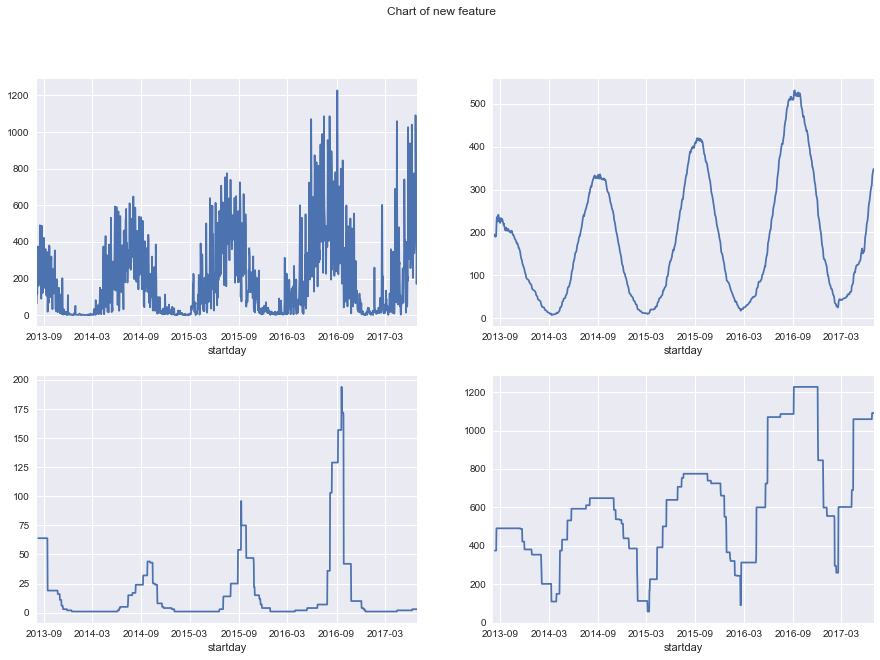

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 10)

model_df1.num_trips.plot(subplots=True, ax=axes[0][0], title='Chart of new feature')
model_df1.num_trips_90mean.plot(subplots=True, ax=axes[0][1])
model_df1.num_trips_90min.plot(subplots=True, ax=axes[1][0])
model_df1.num_trips_90max.plot(subplots=True, ax=axes[1][1])



C:\_Apps\Anaconda\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,min_periods=1,center=False).mean()


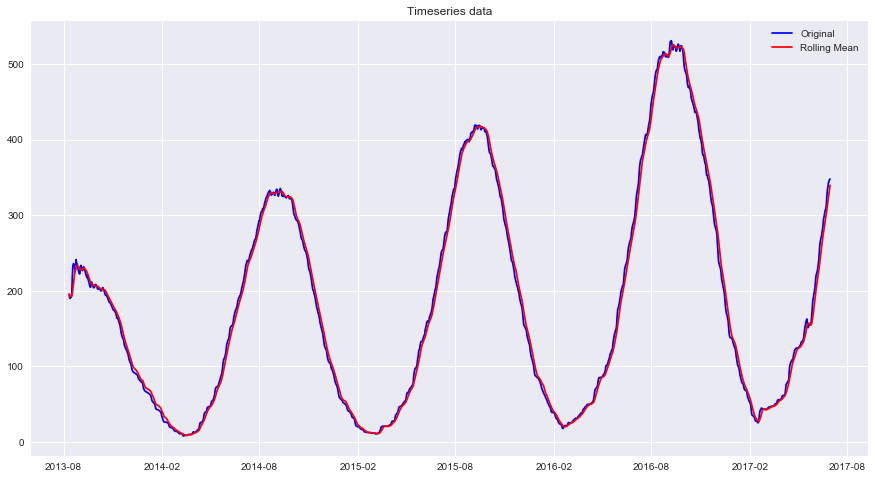

ADF Test result:
ADF Statistic: -5.779134
p-value: 0.000001
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [55]:
#stationary ADF test on 90days rolling data
model_df1.num_trips_90mean.dropna(inplace=True)
isStationary(model_df1.num_trips_90mean)

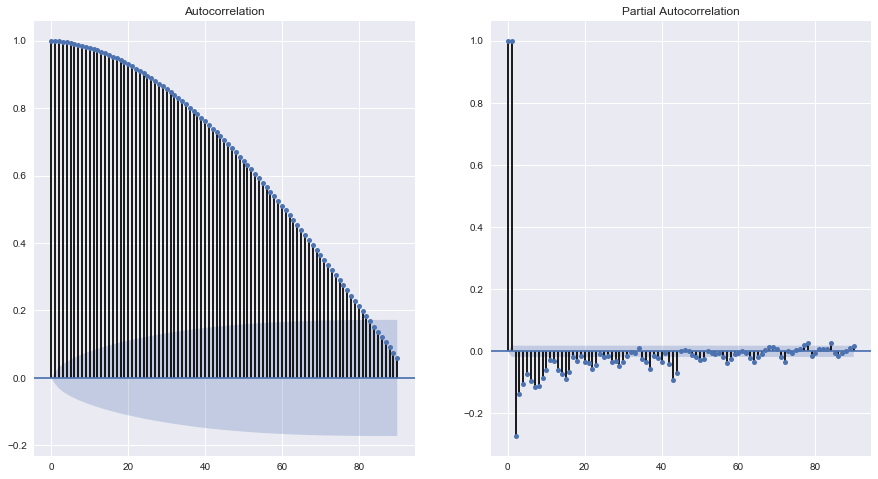

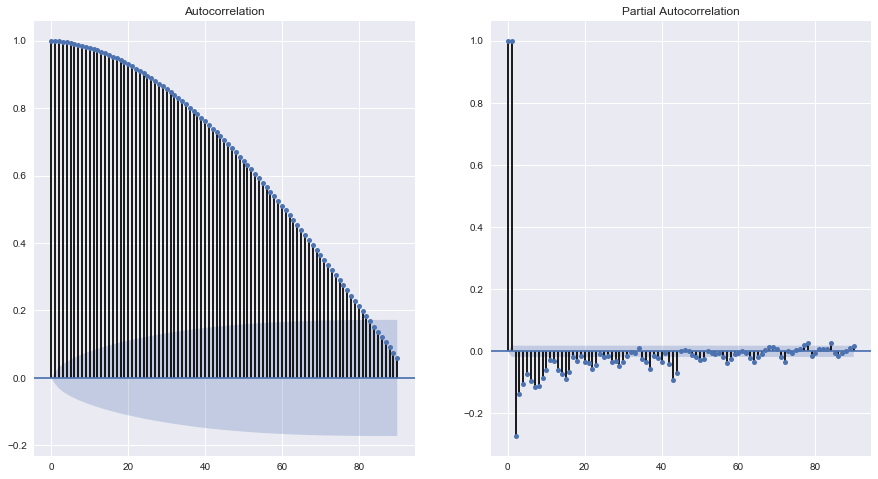

In [67]:
#ACF/PCF plot on 90days mean data.
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_size_inches(15, 8)
plot_acf(model_df1.num_trips_90mean, lags=90, ax=axes[0],  alpha=0.5)
plot_pacf(model_df1.num_trips_90mean, lags=90,  ax=axes[1],  alpha=0.5)


In [70]:
#split data into training, validation, & testing set

temp_df = model_df1.drop(['num_trips', 'num_trips_90min', 'num_trips_90max'], axis=1)
temp_df.dropna(inplace=True)
model_train, model_validate, model_test = train_validate_test_split(temp_df)

#train data
model_train = model_train.reset_index('startday')
model_train = model_train.drop('startday', axis=1)
X_train = model_train.drop('num_trips_90mean',axis=1)
Y_train = model_train['num_trips_90mean']

#validate data
model_validate = model_validate.reset_index('startday')
model_validate = model_validate.drop('startday', axis=1)
X_val = model_validate.drop('num_trips_90mean',axis=1)
Y_val = model_validate['num_trips_90mean']

#test data
model_test = model_test.reset_index('startday')
model_test = model_test.drop('startday', axis=1)
X_test = model_test.drop('num_trips_90mean',axis=1)
Y_test = model_test['num_trips_90mean']

X_train.dtypes

month                  category
tripdate               category
season                 category
IsHoliday              category
humidity                float64
temperatureMax          float64
temperatureMin          float64
windspeed               float64
CLEAR_DAY              category
FOG                    category
PARTLY_CLOUDY_DAY      category
PARTLY_CLOUDY_NIGHT    category
RAIN                   category
SNOW                   category
WIND                   category
dtype: object

In [71]:
#Linear regression model understanding.
clf = LinearRegression(normalize= True)
clf.fit(X_train, Y_train)
rmse = math.sqrt(mean_squared_error(Y_val, clf.predict(X_val)))
print("Accuracy of LR is: ", clf.score(X_val, Y_val), 
      "\nThe RMSE is: ", rmse)
print("cofficient: " , clf.coef_)
print("intercepter: ", clf.intercept_)

Accuracy of LR is:  0.591611782957 
The RMSE is:  124.00672252240669
cofficient:  [  1.25590464e+01   2.82581577e-02   3.57237280e+01  -9.54199465e+00
  -7.46230928e+01   1.14177584e-01   4.93679984e+00  -4.94902492e-01
  -7.12210448e+00  -2.43893757e+01   2.02795752e+01   3.07116028e+00
  -1.23412811e+01   2.04717601e+00   5.29968820e+00]
intercepter:  -142.781260439


In [74]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=200,random_state=0)
rf.fit(X_train, Y_train)
rf.score(X_val, Y_val)
preds = rf.predict(X= X_val)

rmse = math.sqrt(mean_squared_error(Y_val, preds))
print ("RMSE Value For Random Forest: ", rmse)
print("Accuracy: ", rf.score(X_val, Y_val))

RMSE Value For Random Forest:  104.53508065652288
Accuracy:  0.709793682821


In [180]:
from sklearn.metrics import accuracy_score
myaccuracy=accuracy_score(Y_val,preds) 
print(myaccuracy) 


ValueError: Can't handle mix of multiclass and continuous

In [178]:
important_features = pd.Series(data=rf.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)


temperatureMax         0.211396
temperatureMin         0.196735
windspeed              0.174254
humidity_scaled        0.127241
tripdate               0.106824
month                  0.053294
RAIN                   0.053249
season                 0.025206
CLEAR_DAY              0.016959
PARTLY_CLOUDY_DAY      0.010854
PARTLY_CLOUDY_NIGHT    0.009061
WIND                   0.008570
FOG                    0.003865
IsHoliday              0.002473
SNOW                   0.000018
dtype: float64


In [78]:
#fit with ARIMA model 

float_num_trips = temp_df.num_trips_90mean.apply(lambda x : float(x))

float_num_trips_1 = temp_df.num_trips_90mean.apply(lambda x : float(x))
float_num_trips_1.dropna(inplace=True)

model = ARIMA(float_num_trips, order=(0, 0, 0))
results_ARIMA = model.fit(disp=-1)

model = ARIMA(float_num_trips_1, order=(0, 1, 0))
results_ARIMA1 = model.fit(disp=-1)

print(results_ARIMA.summary())
print(results_ARIMA1.summary())

                              ARMA Model Results                              
Dep. Variable:       num_trips_90mean   No. Observations:                 1378
Model:                     ARMA(0, 0)   Log Likelihood               -8788.789
Method:                           css   S.D. of innovations            142.450
Date:                Fri, 17 Nov 2017   AIC                          17581.578
Time:                        23:47:30   BIC                          17592.035
Sample:                    08-11-2013   HQIC                         17585.490
                         - 06-30-2017                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        184.4808      3.837     48.074      0.000       176.960   192.002
                             ARIMA Model Results                              
Dep. Variable:     D.num_trips_90mean   No. Observat

C:\_Apps\Anaconda\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


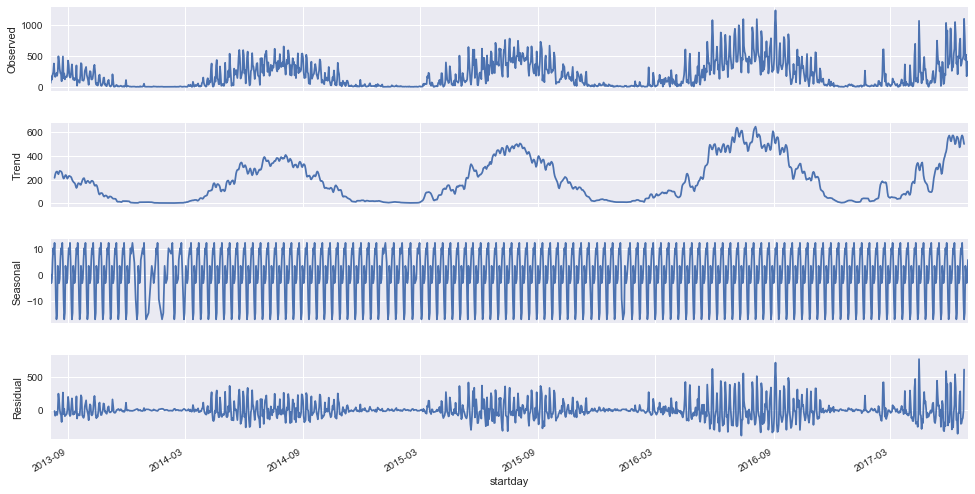

In [113]:
import statsmodels.api as sm


decomposition = sm.tsa.seasonal_decompose(model_df1.num_trips, freq=12)

#decomposition = sm.tsa.seasonal_decompose(temp_df.num_trips_90mean, freq=12) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)


In [106]:
#SARIMAX

import statsmodels.tsa.statespace as sm
#import statsmodels.tsa.statespace as ar 
#import statsmodels.api as sm
#from dismalpy import ssm

mod =  sm.SARIMAX(temp_df.num_trips_90mean, trend='n', order=(0,1,0), seasonal_order=(0,0,1,4))
results = mod.fit()
print(results.summary())

# Fit the model
#mod = ssm.SARIMAX(data['wpi'], trend='c', order=(1,1,1))
#res = mod.fit()
#print(res.summary())



AttributeError: module 'statsmodels.tsa.statespace' has no attribute 'SARIMAX'